 ## $\underline{ \textbf{Data assimilation on a PAPA}}$
 
 
 
 **Statut** :OK
 
**Purpose**: We propose here an assimilation problem whose goal is to infer the mass **m** and moment of inertia **$I_\alpha$** of a PAPA from observations made on displacemenst.
 
 
 **Reference** : 
 
 [1] : [ V. Mons, J.-C. Chassaing, T. Gomez, P. Sagaut, "Reconstruction of unsteady viscous flows using data assimilation schemes", JCP 316 (2016) p. 255-280.](https://dropsu.sorbonne-universite.fr/s/oP8s9CeNS5zW5DG)
 
 [2] : [ A. Chaarane, "Data Assimilation for Flow Induced Vibrations",Stage, InstitutJean Le Rond D’Alembert, 2021.](https://dropsu.sorbonne-universite.fr/s/kr97PiKoJ8jFHfw)
 
 
-----------------------------------
**A. Chaarane**, Institute  D'Alembert, (2 May 2022)

-----------------------------------

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [20]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
import os
import sys
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import copy
# ------ Importation Local
PATH      = "PAPA/Mass_Ialpha_SigML/"
PATH_DATA = "../../DATA/DA_4DEnVar_V2/"+PATH
PATH_CONF = "../../Inference_Problem/PAPA/"
sys.path.append(PATH_CONF)

sys.path.append("../")
from Post_Trait import POSTRAIT
from Post_Trait import Get_FNN_Samples_v2, Get_FNN_Samples, Compute_Bary
PST = POSTRAIT(PATH_DATA)
PST.J_cost =PST.J_cost[:13]
PST.Param_error = PST.Param_error[:13]

### Configuration of the DA problem
We propose here an inference problem on the mass $m$ and the moment of inertia $I_α$ of the structure. The observations were made on the airfoil displacements, pitch and plung, every 0.05 step time  in the time interval [ 0, 1]. The reference and initialization control vectors are defined in the table below along with the observation and ensemble parameters.

In [21]:
PST.show_cfg()

-------------------------------------------------------------------------------------------------------------------
                                                Parametres                                         
--------------------------------------------------------------------------------------------------------------------
     Modele name      :                   PAPA                
     DA Method        :                   4DEnVar (V2)        
     Uncertains param :                                                       
                  name     : mass   I_alpha
                 reference : mass = 87.07   I_alpha = 3.73   
                 estimate  : mass = 75.0   I_alpha = 1.8   
                                                                         
     Nbr Iteration =  20  |  Nbr Ensemble =   30  | Param_sigma = 0.300000
                                                                         
     Observations     :                                                  

### Function Cost


$\newcommand{\Gama}{\boldsymbol{\gamma}} 
\newcommand{\B}{\boldsymbol{B}} 
\newcommand{\C}{\boldsymbol{C}} 
\newcommand{\Gamae}{\boldsymbol{\gamma}^{(e)}}
\newcommand{\YN}{( \boldsymbol{y}{_k})_{0\leq k\leq N}}
\newcommand{\XN}{( \boldsymbol{x}{_k})_{0\leq k\leq N}}
\newcommand{\Ep}{ \boldsymbol{E}'}
\newcommand{\Beta}{ \boldsymbol{\beta}}
\newcommand{\h}{ \boldsymbol{h}}
\newcommand{\x}{ \boldsymbol{x}}
\newcommand{\y}{ \boldsymbol{y}}$

The DA framework addressed in this study is to infer the control vector $\Gama$ assuming that observations $\boldsymbol{y}$  are given by
$\boldsymbol{y}=\boldsymbol{h}(\boldsymbol{x}) +\boldsymbol{\epsilon}^0 $, with $\h$  the observation operator and $\boldsymbol{\epsilon}^0$  the measurement error.
If the model is supposed to be exact,  the control vector is sought as a solution which minimises the following cost function

\begin{align}
J(\Gama) &= \; \frac{1}{2} \Vert \h\big(\x (\Gama)\big) - \y \Vert^2_{\C^{-1}} 
%\textbf{Grad}_{obs} &=\sum_{n=0}^{N} \boldsymbol{H}_k '^T \C^{-1}\boldsymbol{d}\\
%\textbf{Hess}_{obs}&=\sum_{n=0}^{N} \boldsymbol{H}_k '^T \C^{-1}\boldsymbol{H}_k '
\end{align}

where $\C$ denotes the covariance matrix of the measurement error and $ \Vert \cdot \Vert ^2_{\C^{-1}} = \cdot ^T \C ^{-1} \cdot$.

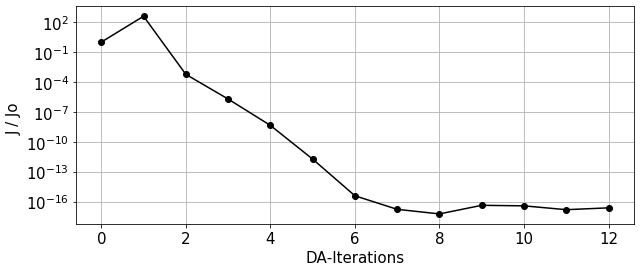

In [ ]:
plt.figure(figsize=(10,4))
PST.plot_Jcost()
N_iter = [i for i in range(len(PST.J_cost))]

new_list = range(math.floor(min(N_iter)), math.ceil(max(N_iter))+1)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


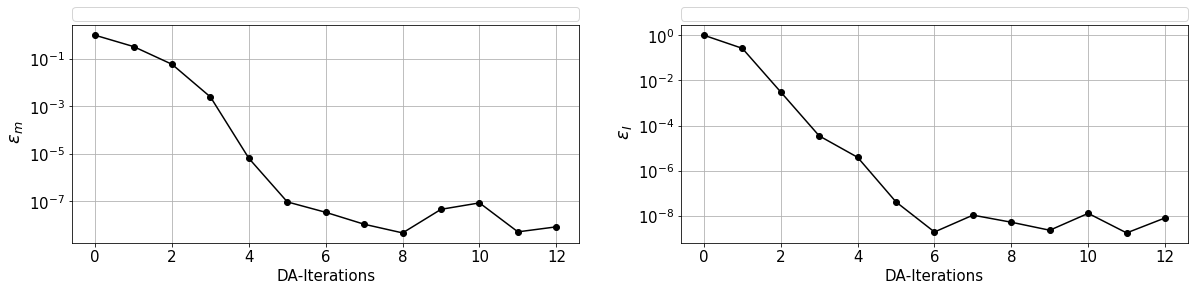

In [ ]:
n_col = 2
plt.figure(figsize=(20,4))

N_iter  = [j for j in range(len(PST.Param_error))]
k=1
y_label = ["m","I"]
for i,name in enumerate(PST.CFG.Param_Name) :
    
    plt.subplot(1,n_col,k)
    plt.plot(N_iter, PST.Param_error[:,i]/PST.Param_error[0,i],'-o', c="k")
    new_list = range(math.floor(min(N_iter)), math.ceil(max(N_iter))+1,2)
    plt.xticks(new_list, fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('DA-Iterations',fontsize=15)
    plt.ylabel(fr" $\epsilon_{y_label[i]}$",fontsize=18)
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                            mode="expand", borderaxespad=0, ncol=4,fontsize=18)    
    plt.grid()
    
    if k ==n_col and i!=len(PST.CFG.Param_Name)-1:
        plt.show()
        plt.figure(figsize=(20,4))
        k=1
    else :
        k+=1

Here we plot the cost function $J$ as a function of the number of iterations, we plot the logarithm of ($J/J_0$) where $J_0$ is the cost caculated with the initialization vector.  We can see that the latter decreases with each iteration and starts to converge around the 3rd iteration. Here we have deactivated the breaking criterion to see the saturation of the cost function. 

### Control Vectors  

In [ ]:
PST.show_param_ref_opti_est(True)

+---------+-------------+------------------+-------------+
|         |   Reference |   Initialisation |   Optimized |
+=========+=============+==================+=============+
| mass    |       87.07 |             75   |       87.07 |
+---------+-------------+------------------+-------------+
| I_alpha |        3.73 |              1.8 |        3.73 |
+---------+-------------+------------------+-------------+


The optimized vector presented here is the control vector obtained with the DA optimization in the last Iteration, we see that it is equal to the reference with a good precision. This shows that our assimilation method is very efficient.

### Reconstruction of airfoil oscillations. 

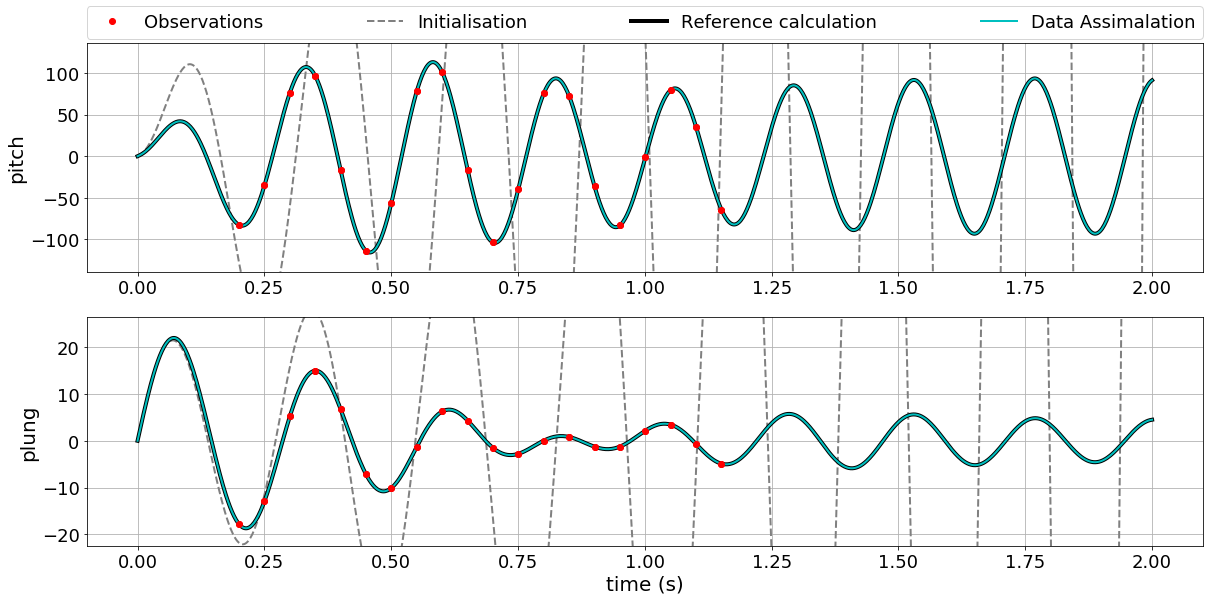

In [ ]:
plt.figure(figsize=(20,100))
PST.plot_obs_ref_est_opt()

We have represented the reconstruction of the airfoil displacements as a function of time. We have in red the observations, in grey the initial calculation which is very far from the reference solution which is in cyan color. We can see that after the optimization process we manage to reconstruct perfectly the displacements of the profile by passing over the observations and which are almost equal to the reference state at long times. 

### Sample analysis during the optimisation process. 

In [ ]:
df_samples = copy.copy(PST.get_samples_df())
df_samples["MSE"] = 0
df_samples["Data"] = ""

df_samples.head(-1)

,mass,I_alpha,DA_Iter,Sample,Solver,MSE,Data
0,67.978416,1.786060,1,0,PAPA,0,
1,72.205822,1.140939,1,1,PAPA,0,
2,81.353758,1.585471,1,2,PAPA,0,
3,71.487889,2.281620,1,3,PAPA,0,
4,69.229683,1.202634,1,4,PAPA,0,
...,...,...,...,...,...,...,...
594,91.810634,4.514777,20,24,PAPA,0,
595,89.997748,3.849074,20,25,PAPA,0,
596,87.738813,3.631938,20,26,PAPA,0,
597,86.663561,2.934936,20,27,PAPA,0,


We display above a part of the samples, we have a total of $N_{ens} \times N_{iter}$ =$40\times 4$  samples. For a better analysis, we can visualize them on the figure above.  

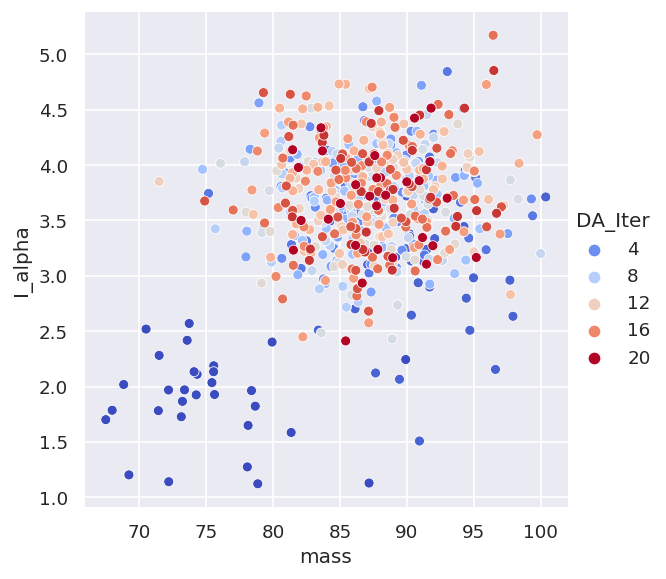

In [57]:
df_samples_zoom =df_samples.loc[ (df_samples["DA_Iter"] >=0)]
with sns.axes_style("darkgrid"):
    ax=sns.relplot(data=df_samples_zoom, x=PST.CFG.Param_Name[0], y=PST.CFG.Param_Name[1],hue ="DA_Iter",palette="coolwarm" )
    ax.fig.set_dpi(120)

Here we represent the samples obtained at each iteration, we can see that from one iteration to the next the samples group together to form a kind of cluster.

### Strategy for combining DA and FNN

In [ ]:
ML_Name = "FNN"

The DA optimisation process is very computationally intensive, as it requires the execution of the HF (High Fidelity) model for all samples at each iteration. We aim to reduce this computational time by replacing the execution of the HF model with a deep learning  model. 

The strategy we will use in this example is as follows: The samples of the first iteration will be propagated with the HF model. Then for the following iterations, if a sample is in a cluster, it will be propagated with the FNN model.

In [ ]:
#Path_FNN = "../../Src_Solver/FNN/"
#sys.path.append(Path_FNN)
#from  Pre_processing_data import PTD_param
#from PAPA_FNN import MyFNN

Path_ML = "../../Src_Solver/"+ ML_Name+"/"
sys.path.append(Path_ML)
from  Pre_processing_data import PTD_param
if ML_Name == "LSTM":
    from PAPA_LSTM import MyLSTM
if ML_Name == "FNN":
    from PAPA_FNN import MyFNN


### Automatic Cluster Detection 

Suppose we are in the iteration $I_{DA} >0$.

for $\gamma_i$ a sample of the current iteration $I_{DA}$, we build a shpere of radius $r_c$ and of center  $\gamma_i$, if this shpere contains samples of the previous iteration then $\gamma_i$ will be considered as a point in the cluster and so it will be propagated with the FNN solver. 



In [ ]:
rayon_cluster = 1/3 *PST.CFG.DA_Param_Sigma
DL_max_ratio  = 0.3

DA_Iter     = 5


###  Example of cluster detection for $I_{DA}$ equals 2

In [ ]:
df_samples_trunc =  df_samples.loc[ (df_samples["DA_Iter"] ==DA_Iter) |  (df_samples["DA_Iter"] ==DA_Iter-1)]
df_samples_trunc_bar  = copy.copy(df_samples_trunc)


for i,parm_nm in enumerate(PST.CFG.Param_Name): 
    df_samples_trunc_bar[parm_nm] =( 2*df_samples_trunc[parm_nm] - PST.CFG.Param_Bounds[i][0] -PST.CFG.Param_Bounds[i][1])\
                    / (PST.CFG.Param_Bounds[i][1]-PST.CFG.Param_Bounds[i][0])
index_0 = df_samples_trunc_bar.index.tolist()[0]



Param_old_bar    = df_samples_trunc_bar.loc[(df_samples["DA_Iter"] ==DA_Iter-1)][PST.CFG.Param_Name].values
Param_new_bar    = df_samples_trunc_bar.loc[(df_samples["DA_Iter"] ==DA_Iter)][PST.CFG.Param_Name].values

Param_old    = df_samples_trunc.loc[(df_samples["DA_Iter"] ==DA_Iter)][PST.CFG.Param_Name].values
Param_new    = df_samples_trunc.loc[(df_samples["DA_Iter"] ==DA_Iter-1)][PST.CFG.Param_Name].values

bary_bar = Compute_Bary(Param_old_bar)
df_samples_trunc_bar=df_samples_trunc_bar.append({'mass' : bary_bar[0] , 'I_alpha' : bary_bar[1], "MSE":0, "Data" : "Bary", "DA_Iter" : DA_Iter-1} , ignore_index=True)


bary     = Compute_Bary(Param_old)
df_samples_trunc=df_samples_trunc.append({'mass' : bary[0] , 'I_alpha' : bary[1], "MSE":0, "Data" : "Bary", "DA_Iter" : DA_Iter-1} , ignore_index=True)

            
Param_train_bar  ,Param_test_bar =Get_FNN_Samples_v2(Param_old_bar, Param_new_bar, rayon_cluster,DL_max_ratio)   


In [ ]:
for index in df_samples_trunc_bar.index: 
    if df_samples_trunc_bar[PST.CFG.Param_Name[0]][index] in Param_test_bar[:,0] and df_samples_trunc_bar[PST.CFG.Param_Name[1]][index] in Param_test_bar[:,1] :
        df_samples_trunc_bar["Data"][index] = "Pred"
        df_samples_trunc["Data"][index] = "Pred"
    else :
        if df_samples_trunc_bar["Data"][index] != "Bary" :
            df_samples_trunc_bar["Data"][index] = "Train"
            df_samples_trunc["Data"][index] = "Train"


/tmp/ipykernel_3577497/3286507808.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples_trunc_bar["Data"][index] = "Train"
/tmp/ipykernel_3577497/3286507808.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples_trunc["Data"][index] = "Train"
/tmp/ipykernel_3577497/3286507808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples_trunc_bar["Data"][index] = "Pred"
/tmp/ipykernel_3577497/3286507808.py:4: SettingW

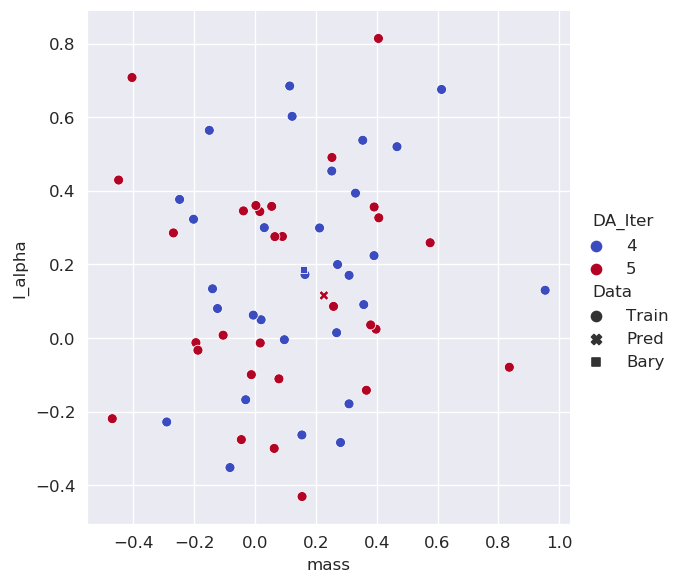

In [ ]:
with sns.axes_style("darkgrid"):
    ax=sns.relplot(data=df_samples_trunc_bar, x=PST.CFG.Param_Name[0], y=PST.CFG.Param_Name[1],hue ="DA_Iter",palette="coolwarm", style="Data" )
    ax.fig.set_dpi(120)

We plot here in blue the samples of the previous iteration, and in red the samples of the current iteration. The round dots (blue and red) represent the samples that will be propagated with the HF (High Fidelity) solver. The results obtained from the propagation of the round points will be used to train the DL (Deep Learning) solver to predict the results of the cross points (red).

### Example of propagation of the DL solver

In [ ]:
def MyFOM(param) :
    # param = [m,I]
    
    # on recupere le numero du sample et de l'iteration
    # on parcours tout les samples et on s'arrete si mass = param[0] and mass = param[]
    n_iter_samp =df_samples.loc[(df_samples[PST.CFG.Param_Name[0]] == param[0]) & \
                        (df_samples[PST.CFG.Param_Name[1]] == param[1])][["DA_Iter", "Sample"]].values[0]
    
    n_iter = n_iter_samp[0]; n_sample = n_iter_samp[1]
    obsvervables = PST.get_observables_of_sample(n_iter,n_sample) 
    
    if np.isnan(obsvervables).any() :
        print("Warning !!!!!")
        print("NaN found in ")
        print(f"n_iter = {n_iter} and n_sample = {n_sample}")   
    return  obsvervables  



In [ ]:
## import tensorflow
# deactivate CUDA
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Flatten,Dense

prfx = ML_Name+"/"+PATH
folder = "../../DATA/Notebook/"

In [ ]:
n_time           = len(PST.time)
n_features       = PST.CFG.Param_Dim
input_shape      = (n_time,n_features+1)

In [ ]:
def MyFNN(input_shape,n_out, N_layer=2, N_units = 30, learning_rate=1e-4):
    model              =  Sequential()
    initializer        =  tf.keras.initializers.GlorotUniform(seed=101)
    optimizer          =  tf.keras.optimizers.Adam(learning_rate=learning_rate) 
    bias_initializer   =  tf.keras.initializers.Zeros()
    kernel_regularizer =  tf.keras.regularizers.l2(l2=0)
    model.add(Dense(N_units, kernel_regularizer=kernel_regularizer,activation='tanh',bias_initializer=bias_initializer,kernel_initializer=initializer,input_shape=input_shape))
    
    for layer in range(N_layer-1) :
        model.add(Dense(N_units, kernel_regularizer=kernel_regularizer,activation='tanh',bias_initializer=bias_initializer,kernel_initializer=initializer))
    
    model.add(Flatten())
    model.add(Dense(n_out))
    
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

model = MyFNN(input_shape,2*n_time)
#model.summary()


2022-06-02 15:17:35.881349: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-02 15:17:35.881430: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: cael
2022-06-02 15:17:35.881442: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: cael
2022-06-02 15:17:35.881610: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2022-06-02 15:17:35.881653: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2022-06-02 15:17:35.881661: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.47.3
2022-06-02 15:17:35.882048: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

## Training 

In [ ]:
df_samples_train = df_samples_trunc.loc[ (df_samples_trunc["Data"] =="Train")]
df_samples_test  = df_samples_trunc.loc[ (df_samples_trunc["Data"] =="Pred")]
dim_obs = len(PST.CFG.Obs_Name)

In [ ]:
n_out       = dim_obs * n_time

if ML_Name == "LSTM":
    model       = MyLSTM(input_shape,n_out,N_layer=1, N_units = 500, learning_rate=5e-4)
if ML_Name == "FNN":
    model       = MyFNN(input_shape,n_out,N_layer=5, N_units = 20 , learning_rate=5e-4)
    
Param_train = df_samples_train[PST.CFG.Param_Name].values
Param_test  = df_samples_test[PST.CFG.Param_Name].values
PTD         = PTD_param(model, PST.time,MyFOM, Param_train, Param_test, Param_vald=np.array([]),
                                 folder = folder, prfx=prfx)

PTD.Get_Dataset()



---- Data Training -------:
        mu shape          :  (59, 2)
        X_train  shape    :  (59, 1000, 3)
        Y_train  shape    :  (59, 2000)


---- Data Test -----------:
        mu shape          :  (1, 2)
        X_test  shape     :  (1, 1000, 3)
        Y_test  shape     :  (1, 2000)



time  shape    :  (1000,)



In [ ]:
PTD.Myfit(epochs = 800, batch_size=512, verbose = 0, validation=False, overwrite=True)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/avicene/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3577497/3131046377.py", line 1, in <module>
    PTD.Myfit(epochs = 800, batch_size=512, verbose = 0, validation=False, overwrite=True)
  File "/home/avicene/Documents/These/CODE/DATA_ASSIMILATION/DA_2.2/Notebooks/PAPA/../../Src_Solver/FNN/Pre_processing_data.py", line 229, in Myfit
    history =  self.model.fit(self.X_train, self.Y_train, epochs=epochs ,batch_size=batch_size,  verbose=verbose)
  File "/home/avicene/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/home/avicene/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
    tmp_logs = self.train_function(iterator)
  File "/home/avicene/.local/lib/python3.8/site-packages/tensorflow/python/util/tr

TypeError: object of type 'NoneType' has no len()

In [ ]:
PTD.plot_loss(key=['loss'],figsize=(10,4))

#### Prediction    


In [ ]:
y=PTD.Mypredict(Param_test=Param_test,version=1, overwrite=True, mse=True)

In [ ]:
PTD.plot_truth_predi(Param_test=Param_test,figsize=(20,8),name_mu = "[m, I]", ylabel = "Pitch", ylabel2= "Plung")


In [ ]:
# PTD.name="FNN"
# PTD.all_info()
#print("")

In [ ]:
i =0
index_0 = df_samples_trunc.index.tolist()[0]
for prm in Param_test :
    index = df_samples_trunc.loc[ (df_samples_trunc[PST.CFG.Param_Name[0]] ==prm[0]) &  \
                         (df_samples_trunc[PST.CFG.Param_Name[1]] ==prm[1])    ].index 
    df_samples_trunc.iloc[index[0]-index_0,-2]  = PTD.info_mse[i]
    i+=1

In [ ]:
with sns.axes_style("darkgrid"):
    ax=sns.relplot(data=df_samples_trunc, x=PST.CFG.Param_Name[0], y=PST.CFG.Param_Name[1],hue ="Data",size="MSE",sizes=(20, 80),palette="mako")
    ax.fig.set_dpi(120)